In [117]:
import numpy as np
import matplotlib.pyplot as plt

def generate_signal(spectrum_bins, spectrum_pdf, rate, T_total=400e-6,
                    pulse_width=25e-9, dt=1e-9, gain=1.0):
    """"
    | 参数        | 含义                                                  | 典型值          
    -----------   | -----------------------------------------------------  
    spectrum_bins | 能谱的能量区间(单位 keV),例如 [0, 1, 2, ..., 100]      | 实验能谱能量边界       
    spectrum_pdf  | 每个能量区间对应的概率或强度(未必归一化)                | 来自实验或模拟的能谱     
    rat           | 入射光子计数率(单位:counts/s)                          | 1e5 ~ 1e7     
    T_total       | 采样积分总时间(秒)                                     | 400e-6 (400 μs)   
    pulse_width   | 每个脉冲宽度(秒)                                       | 25e-9 (25 ns) 
    dt            | 采样时间步长(秒)                                       | 1e-9 (1 ns)   
    gain          | 幅度放大系数，用于将能量转成信号幅度                    | 可设 1.0       
    """
    # 归一化谱
    pdf = spectrum_pdf / np.sum(spectrum_pdf)
    # pdf = spectrum_pdf
    cdf = np.cumsum(pdf)
    bin_centers = (spectrum_bins[:-1] + spectrum_bins[1:]) / 2

    # 泊松过程生成到达时间
    t, times = 0.0, []
    while t < T_total:
        t += np.random.exponential(1.0 / rate)
        if t < T_total:
            times.append(t)
    times = np.array(times)

    # 根据谱抽样能量
    u = np.random.rand(len(times))
    idx = np.searchsorted(cdf, u)
    energies = bin_centers[np.clip(idx, 0, len(bin_centers) - 1)]
    amplitudes = gain * energies

    # 生成时间轴与信号
    t_axis = np.arange(0, T_total, dt)
    signal = np.zeros_like(t_axis)

    pulse_samples = int(pulse_width / dt)
    for ti, Ai in zip(times, amplitudes):
        i0 = int(ti / dt)
        i1 = min(i0 + pulse_samples, len(signal))
        signal[i0:i1] += Ai

    return t_axis, signal, times, amplitudes


In [118]:
# ---------- 读取谱文件 spek_120.txt ----------
# 如果文件第一行是列名（header），加 skiprows=1
data = np.loadtxt('spectrum_file/spek_120.txt', skiprows=1)   # 或 np.loadtxt('spek_120.txt', skiprows=1)
energies = data[:,0]   # 能量点，单位 keV (应该从 12 到 120)
values = data[:,1]     # 对应强度（任意单位）

# ---------------- 构建 bins 和 pdf ----------------
# 假设每行是逐 keV 的中心值（12,13,...,120），我们把每个能量视为 bin center，
# 将 bin edges 设为以 0.5 keV 为半宽度的等间隔边界（即 11.5-12.5, 12.5-13.5,...）
emin = energies.min() - 0.5
emax = energies.max() + 0.5
bins = np.arange(emin, emax + 1e-6, 1.0)   # edges every 1 keV

# 如果你的 file 有不规则能量间隔，请用 np.concatenate([...]) 构造 edges
# 例如： bin_edges = np.concatenate([energies - 0.5, energies[-1] + 0.5])

# 使用读取的 values 作为谱强度（pdf 需要归一化）
pdf = values.copy()
pdf = pdf / np.sum(pdf)
# 注意：这里 pdf 的长度应等于 len(bins)-1 (若存在 off-by-one 请检查 bins 构造)


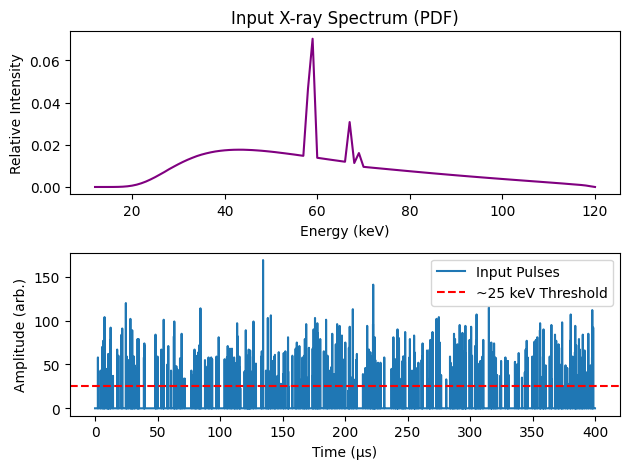

In [119]:

# 示例：虚拟谱（两个峰）
# bins = np.linspace(0, 100, 101)
# pdf = 0.7*np.exp(-(bins[:-1]-30)**2/(2*3**2)) + 0.3*np.exp(-(bins[:-1]-70)**2/(2*2**2))

# 入射率 1e6 cps
t, sig, times, amps = generate_signal(bins, pdf, rate=1e6, T_total=400e-6,
                                      pulse_width=25e-9, dt=1e-9, gain=1.0)

# (1) 光谱（能量分布）
plt.subplot(2,1,1)
plt.plot((bins[:-1] + bins[1:]) / 2, pdf, color='purple')
plt.xlabel('Energy (keV)')
plt.ylabel('Relative Intensity')
plt.title('Input X-ray Spectrum (PDF)')

# (2) 时间波形
plt.subplot(2,1,2)
plt.plot(t*1e6, sig, label='Input Pulses')
plt.axhline(25, color='r', linestyle='--', label='~25 keV Threshold')
plt.xlabel('Time (μs)')
plt.ylabel('Amplitude (arb.)')
plt.legend()
plt.tight_layout()
plt.show()


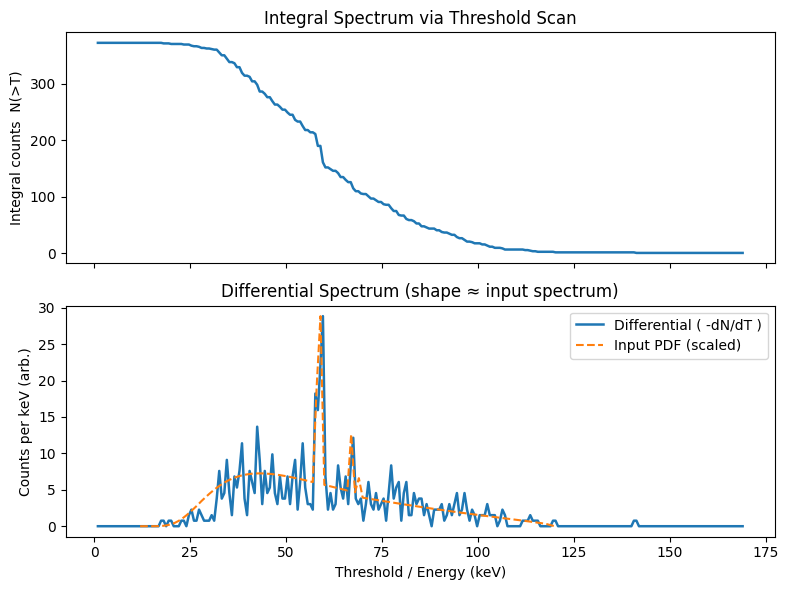

In [120]:
import numpy as np
import matplotlib.pyplot as plt

# --- 阈值扫描参数 ---
dt = t[1] - t[0]                   # 采样间隔
thr_min = 1.0
# thr_max = 257
thr_max = sig.max() #* 1.05
n_thr   = 256                      # 阈值点数（可调）
thr_vals = np.linspace(thr_min, thr_max, n_thr)


def count_crossings(sig, thr):
    """计算信号从 <thr 到 >=thr 的上升沿个数（事件数）"""
    above = sig >= thr          #找出大于阈值的值
    # 上升沿：当前为 True 且前一采样为 False
    rise = above & np.roll(~above, 1)   # 检测为上升沿的值
    # 防止首样本被误计
    rise[0] = False
    return int(rise.sum())

# --- 扫描阈值，得到积分谱 N(>T) ---
integral_counts = np.array([count_crossings(sig, thr) for thr in thr_vals])

# --- 微分谱：对积分谱随阈值做负梯度 ---
# 用梯度近似 -dN/dT（注意单位 ~ counts/幅度）
differential = -np.gradient(integral_counts, thr_vals)

# 如果你的 gain=1，那么“幅度=能量(keV)”；否则这里可做 thr_vals/gain 的能量轴换算
energy_axis = thr_vals  # keV（在你的 generate_signal 里 gain=1.0）

# --- 画图：积分谱 & 微分谱（与输入pdf作形状对比）---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# 积分谱（阈值越高，计数越少）
ax1.plot(energy_axis, integral_counts, lw=1.8)
ax1.set_ylabel('Integral counts  N(>T)')
ax1.set_title('Integral Spectrum via Threshold Scan')

# 微分谱（应近似输入能谱形状；仅差一个尺度因子）
ax2.plot(energy_axis, differential, lw=1.8, label='Differential ( -dN/dT )')

# 可选：把输入 pdf 归一后缩放到可见范围作对比（仅形状对比）
# 这里简单按最大值对齐
orig_centers = (bins[:-1] + bins[1:]) / 2
pdf_norm = pdf / pdf.max() * differential.max() if differential.max() > 0 else pdf
ax2.plot(orig_centers, pdf_norm , '--', label='Input PDF (scaled)')

ax2.set_xlabel('Threshold / Energy (keV)')
ax2.set_ylabel('Counts per keV (arb.)')
ax2.set_title('Differential Spectrum (shape ≈ input spectrum)')
ax2.legend()
plt.tight_layout()
plt.show()
